# Assignment 2 (William Cromar)

In this analysis, I will investigate the effect of interior area, number of rooms, age and house type on the sale prices of a houses in my area.

The complete dataset (data.csv) includes residential, single family homes in Orange County FL, from the past three years (as of March 15, 2017). Sales less than $100 dollars have been excluded from the dataset.

Data was queried from the Orange County Property Appraiser's website, using the Sales Search utility. [Link](http://www.ocpafl.org/searches/ParcelSearch.aspx)

Assume an alpha of .05.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

## Data

This is where Python really shines. I'll import the data from a csv, eliminate some data points to narrow the scope of this analysis, and munge the data a little bit into a format that I can use.

In [2]:
# Read in the data from the CSV
data_raw = pd.read_csv("data.csv")

# Only include sales of type "SALE QUALIFIED AS RESULT OF DEED EXAMINATION" (code 1 in the dataset)
data_raw = data_raw[data_raw["SaleDescriptionCode"] == 1]

# Pull the year out of each year's time stamp
# Time stamps follow the form MM/DD/YYYY HH:MM:SS
data_raw["Year Sold"] = data_raw["Date of Sale"].map(lambda timestamp: int(timestamp.split(" ")[0].split("/")[2]))

# I'm also going to drop datapoints that were built after they were sold (ie building plans)
data_raw = data_raw[data_raw["Average Year Built"] <= data_raw["Year Sold"]]

# Determine the house's age at the time of sale
data_raw["Age at Sale"] = data_raw["Year Sold"] - data_raw["Average Year Built"]

In [3]:
# Extract useful data from data_raw
data = pd.DataFrame()
data["VALUE"] = data_raw["Sale Amount"]
data["BED"] = data_raw["Bedrooms"]
data["BATH"] = data_raw["Bathrooms"]
data["AREA"] = data_raw["Heated Area"]
data["AGE"] = data_raw["Age at Sale"]
data["TYPE"] = data_raw["Property Use Type"]

print data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6197 entries, 0 to 9999
Data columns (total 6 columns):
VALUE    6197 non-null int64
BED      6197 non-null int64
BATH     6197 non-null float64
AREA     6197 non-null int64
AGE      6197 non-null int64
TYPE     6197 non-null object
dtypes: float64(1), int64(4), object(1)
memory usage: 338.9+ KB
None


In [57]:
data.head()

,VALUE,BED,BATH,AREA,AGE,TYPE,GROUP,G0,G1,G2,G3
0,425000,4,3.5,3554,9,SINGLE FAMILY CLASS III,2,False,False,True,False
1,316900,4,2.5,2303,0,SINGLE FAMILY CLASS III,2,False,False,True,False
2,300000,4,3.0,2710,1,SINGLE FAMILY CLASS III,2,False,False,True,False
4,199900,3,2.0,1528,22,SINGLE FAMILY CLASS III,2,False,False,True,False
5,123000,3,1.0,1181,33,SINGLE FAMILY CLASS III,2,False,False,True,False


## Visualizations

Let's try to visualize the interactions between variables.

### Relationships between numerical variables

Next up, let's visualize the relationships between the numerical variables in the dataset.

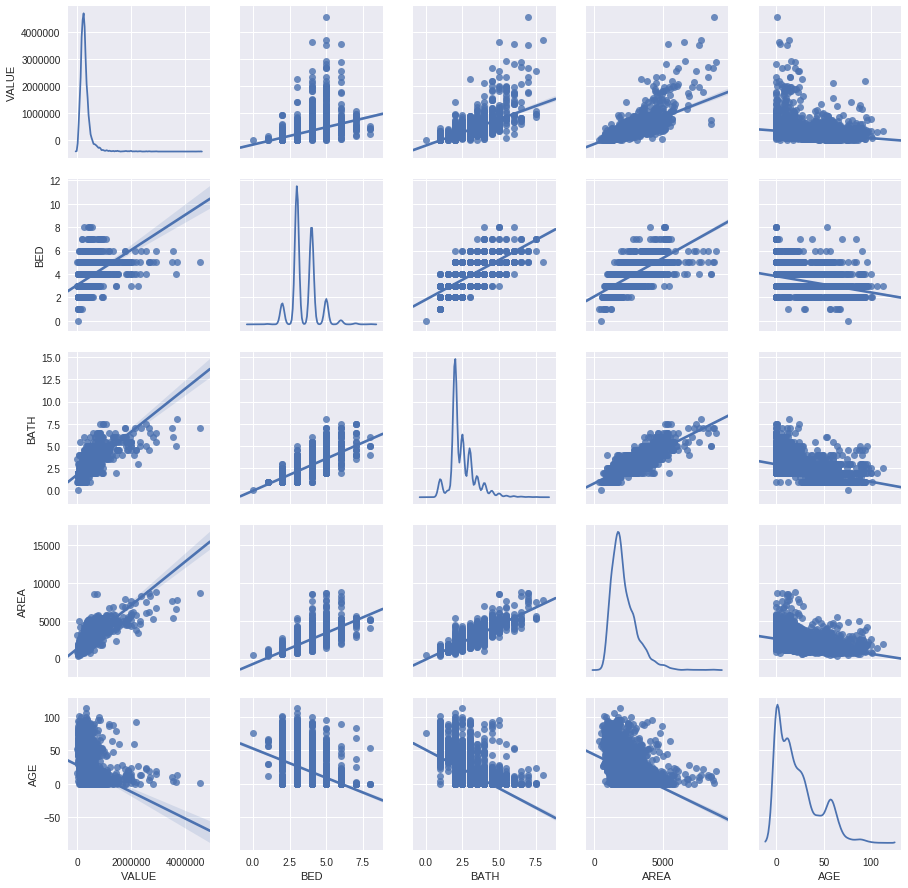

In [4]:
sns.pairplot(data=data.drop(["TYPE"], axis=1), kind="reg", diag_kind="kde")

Here are some quick observations:
1. Looking at the top row, value seems to most strongly correlated with heated area, but also seems to be somewhat correlated with the number of bedrooms and bathrooms, respectively. Value seems to be mostly uncorrelated with the age of the house at the time of its sale.
2. There are strong co-linearities between independent variables. Particularly, the number of bedrooms and bathrooms seems to be quite co-linear with the heated area of the house. This makes sense: adding a room to house will add to its interior area.

### Nominal Variable: Type

Next, let's see if the nominal variable (home type) has any significant impact on the value of that home.

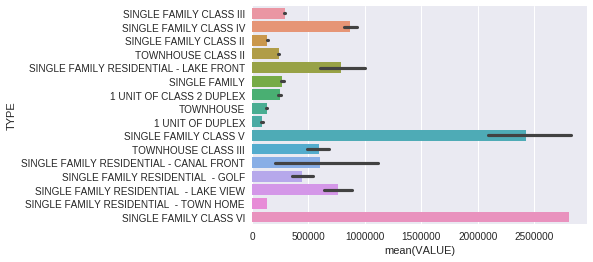

In [5]:
sns.barplot(x="VALUE", y="TYPE", data=data)

There appear to be several classes that are quite close to each other (eg single family and townhouse class II) and and two classes that only have one sample (in particular, single family residential adn single family class VI). I'm hesitant to include TYPE as an independent variable at the moment, since the model will overfit to the smaller types, especially the ones with only one sample.

A possible solution might be to employ cluster analysis on the mean values of each house type.

TYPE
1 UNIT OF CLASS 2 DUPLEX                   2.442652e+05
1 UNIT OF DUPLEX                           9.276364e+04
SINGLE FAMILY                              2.684957e+05
SINGLE FAMILY CLASS II                     1.349991e+05
SINGLE FAMILY CLASS III                    2.890403e+05
SINGLE FAMILY CLASS IV                     8.710197e+05
SINGLE FAMILY CLASS V                      2.428392e+06
SINGLE FAMILY CLASS VI                     2.806500e+06
SINGLE FAMILY RESIDENTIAL  - GOLF          4.465000e+05
SINGLE FAMILY RESIDENTIAL  - LAKE VIEW     7.642500e+05
SINGLE FAMILY RESIDENTIAL  - TOWN HOME     1.300000e+05
SINGLE FAMILY RESIDENTIAL - CANAL FRONT    6.019800e+05
SINGLE FAMILY RESIDENTIAL - LAKE FRONT     7.885806e+05
TOWNHOUSE                                  1.293362e+05
TOWNHOUSE CLASS II                         2.350485e+05
TOWNHOUSE CLASS III                        5.948500e+05
Name: VALUE, dtype: float64


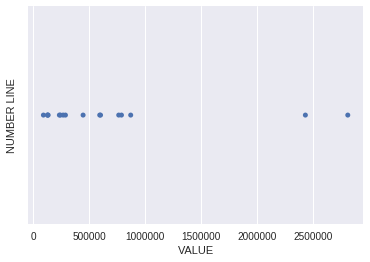

In [6]:
# Find the mean value of each type
tmeans = data.groupby(["TYPE"]).mean()["VALUE"]

# Create dataframe to store TYPE information -- it will make visualizations more convenient
typedf = pd.DataFrame(tmeans)

# This is a hack to make seaborn (sns) display the number line nicely later on -- ignore it
typedf["NUMBER LINE"] = ""

# Plot the means on the number line
#plt.scatter(tmeans.as_matrix(), np.zeros(len(tmeans)))
sns.stripplot(x="VALUE", y="NUMBER LINE", data=typedf)

To my eyes, there appear to be about four clusters of points. I'll use sklearn for the cluster analysis.

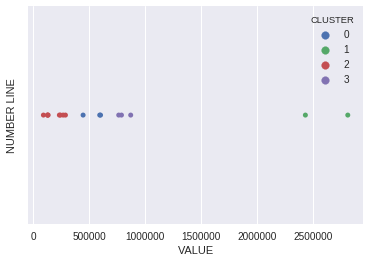

In [7]:
from sklearn.cluster import KMeans

# Initialize KMeans with 4 cluster centers
clf = KMeans(n_clusters=4, random_state=42)

# Fit clf to the means
clf.fit(tmeans.as_matrix().reshape(-1, 1))

# Assign each type to one of the four clusters
# Note: sklean gives a list for cluster predictions, so I'll go through and pull
# out the first element of each list
clusters = tmeans.map(clf.predict).map(lambda lst: lst[0])

# Include in type dataframe in format
typedf["CLUSTER"] = clusters

# Visualize clustering
# Each horizontal level represents a distinct cluster
sns.stripplot(x="VALUE", y="NUMBER LINE", hue="CLUSTER", data=typedf)

# Drop the dummy column now that we're done with visualizations -- also ignore this
typedf.drop("NUMBER LINE", axis=1, inplace=True)

In [8]:
# Looks good! Next, I'll add the cluster designation as a column called "group"
data["GROUP"] = data["TYPE"].map(clusters.get)
# Mean price for each group
print data.groupby("GROUP").mean()["VALUE"]

GROUP
0    5.576667e+05
1    2.443516e+06
2    2.574991e+05
3    8.576012e+05
Name: VALUE, dtype: float64


## Model

Now that I have all of my variables set up, it's time to start building the model.


### Minimal model

I'll start with the most basic model: a linear regression between home sale price and heated area.
I will also test the null hypothesis that there is no correlation between the two variables.

In [9]:
from statsmodels.formula.api import ols

model_min = ols("VALUE ~ AREA", data=data).fit()
print model_min.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     7992.
Date:                Wed, 22 Mar 2017   Prob (F-statistic):               0.00
Time:                        12:31:48   Log-Likelihood:                -83242.
No. Observations:                6197   AIC:                         1.665e+05
Df Residuals:                    6195   BIC:                         1.665e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -1.35e+05   5211.224    -25.903      0.0

The p-value of the F statistic is below 0.00, which is less than my stated alpha of .05. Thus, I can reject the null hypothesis that heated area and home value are uncorrelated.

Looking at the parameters, it seems that every additional square foot of heated area adds about $196 to a home's value. The intercept is meaningless in this context, since it's outside of the range of the data.

Here's what the model looks like:

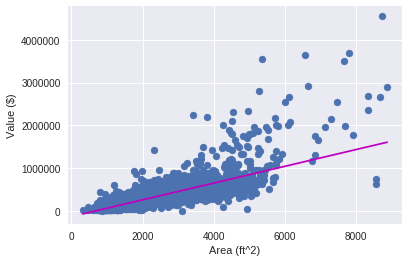

In [58]:
# Scatterplot the data
plt.scatter(data["AREA"], data["VALUE"])

# Extract the model's paramters
inter, slope = model_min.params

# Find the minimum and maximum points in the dataset (by AREA)
pts = np.array([data["AREA"].min(), data["AREA"].max()])

# Compute and plot the predictions for those two points
pred = inter + slope * pts
plt.plot(pts, pred, color='m')

# Name axes
plt.xlabel("Area (ft^2)")
plt.ylabel("Value ($)")

### Adding rooms to the model

Next, I'll include information on how many rooms are in the home. I'll use the partial F test to test the null hypothesis that room information does not contribute significant predictive value.

In [11]:
model_rooms = ols("VALUE ~ AREA + BED + BATH", data=data).fit()
print model_rooms.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     3219.
Date:                Wed, 22 Mar 2017   Prob (F-statistic):               0.00
Time:                        12:31:49   Log-Likelihood:                -82897.
No. Observations:                6197   AIC:                         1.658e+05
Df Residuals:                    6193   BIC:                         1.658e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.872e+04   8861.854     -2.112      0.0

The new variables slightly increased the R^2 value, but these results are strange -- according to the model, adding bedrooms to an existing house decreases its value by $8,469. This is clearly false. This issue is likely due to BATH's correlation with AREA.

Below is the F test comparing this model to the last one:

(I'll write the test as a function, so I can use it later on)

In [59]:
from statsmodels.stats.anova import anova_lm

def partialF(model_red, model_com):
    # Run ANOVA to find the SSE/RSS
    anova_red = anova_lm(model_red)
    anova_com = anova_lm(model_com)

    RSS_red = anova_red["sum_sq"]["Residual"]
    RSS_com = anova_com["sum_sq"]["Residual"]

    # Number of samples and DF of complete model, respectively
    n = len(data)
    k = model_com.df_model

    # Degrees of freedom for numerator and denominator, respectively
    dfn = k - model_red.df_model
    dfd = (n - k - 1)

    # Calculate the F statistic and p-value
    numer = (RSS_red - RSS_com) / dfn
    denom = RSS_com / dfd
    F = numer / denom
    
    # Find the area to the right of the F statistic
    p_value = 1 - sp.stats.f.cdf(F, dfn, dfd)
    
    return F, p_value

In [60]:
F, p_value = partialF(model_min, model_rooms)
print "F-statistic:", F 
print "p-value:", p_value

F-statistic: 363.772786227
p-value: 1.11022302463e-16


The partial F test yields quite a significant test statistic -- the p-value is far below my alpha of .05. Thus, I can reject the null hypothesis that including BED and BATH gives no predictive value, despite the odd parameter estimates. I will, however, revisit this.

### Including age in the model

Next, I will test the null hypothesis that a house's age at the time of sale yields no significant predictive value. I'll use the same partial F test function to test the validity of the new parameter.

In [13]:
model_age = ols("VALUE ~ AREA + BED + BATH + AGE", data=data).fit()
print model_age.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2610.
Date:                Wed, 22 Mar 2017   Prob (F-statistic):               0.00
Time:                        12:31:49   Log-Likelihood:                -82748.
No. Observations:                6197   AIC:                         1.655e+05
Df Residuals:                    6192   BIC:                         1.655e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.092e+05   1.01e+04    -10.834      0.0

It seems that additional years of age, in general, add a fair bit of value to a house, with the parameter estimate being an increase in $1,806 per one year increase in age. Now, for the partial F test of the AGE parameter:

In [14]:
F, p_value = partialF(model_rooms, model_age)
print "F statistic:", F
print "p-value:", p_value

F statistic: 306.24143148
p-value: 1.11022302463e-16


The p-value for the partial F test statistic is below my alpha of .05. Thus, I can reject the null hypothesis that a home's at at the time of its sale has little predictive value for its sale price.

### Including house type in the model

Finally, it's time to test the last independent variable: house type. Recall that I have used cluster analysis to combine the house type assignments into 4 groups, which I will treat as a nominal variable.

Again, I'll use my partialF function to determine if the new variable has any significant predictive value.

In [15]:
# Add terms for each group type in the model
# The value for the GN column will be 1 if the house is part of group N, and 0 otherwise
data["G0"] = data["GROUP"] == 0
data["G1"] = data["GROUP"] == 1
data["G2"] = data["GROUP"] == 2
data["G3"] = data["GROUP"] == 3

model_type = ols("VALUE ~ AREA + BED + BATH + AGE + G0 + G1 + G2 + G3", data=data).fit()
print model_type.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     3703.
Date:                Wed, 22 Mar 2017   Prob (F-statistic):               0.00
Time:                        12:31:49   Log-Likelihood:                -80708.
No. Observations:                6197   AIC:                         1.614e+05
Df Residuals:                    6189   BIC:                         1.615e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     3.9e+05      1e+04     38.823      0.0

In [16]:
F, p_value = partialF(model_age, model_type)
print "F statistic:", F
print "p-value:", p_value

F statistic: 1922.36129363
p-value: 1.11022302463e-16


The partial F test yielded a huge test statistic which falls far my below my stated alpha. Thus, I can reject the null hypothesis that house type has not significant impact on that house's value. In fact, it seems to be one of the most predictive variables that I have added.

The most valuable type of house seems to be Group 1, which includes the following:

In [61]:
# Group with highest offeset
typedf[typedf["CLUSTER"] == 1]

,VALUE,CLUSTER
TYPE,,
SINGLE FAMILY CLASS V,2.428392e+06,1
SINGLE FAMILY CLASS VI,2.806500e+06,1


In [62]:
# Group with lowest offset
typedf[typedf["CLUSTER"] == 3]

,VALUE,CLUSTER
TYPE,,
SINGLE FAMILY CLASS IV,871019.718310,3
SINGLE FAMILY RESIDENTIAL - LAKE VIEW,764250.000000,3
SINGLE FAMILY RESIDENTIAL - LAKE FRONT,788580.555556,3


### Re-visiting the bedrooms parameter

The current large, negative value of BED's coefficient doesn't really make any sense: clearly, houses with fewer bedrooms are not more valuable than those with more bedrooms. This strange behavior could be a result of BED having a correlation with AREA. That hypothesis can be easily tested:

r = 0.733170724896


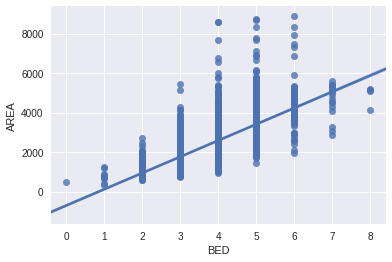

In [53]:
# Plot the regression line
sns.regplot(x="BED", y="AREA", data=data)

# Compute correlation matrix, and grab the r for AREA and BED (off diagonal)
print "r =", np.corrcoef(data[["AREA", "BED"]].as_matrix().T)[0][1]

With such a high correlation with AREA, it may be the case that BED does not add significant value to the model when AREA is already included. To test that hypothesis, I'll use two approaches:
1. A partial F test, comparing the complete model with the BED parameter and one without it.
2. Comparing AIC of the same two models, as decribed by [Wikipedia](https://en.wikipedia.org/wiki/Akaike_information_criterion). AIC rewards a model's goodness of fit, but penalizes extra parameters. A lower score is preferred.

In [63]:
model_nobed = model_inter = ols("VALUE ~ AREA + BATH + AGE + G0 + G1 + G2 + G3", data=data).fit()

# Partial F test
F, p_value = partialF(model_nobed, model_type)
print "F statistic:", F
print "p-value:", p_value

# Blank line
print ""

# AIC comparision
print "AIC of complete model:", model_type.aic
print "AIC of reduced model: ", model_nobed.aic

F statistic: 310.79911534
p-value: 1.11022302463e-16

AIC of complete model: 161431.283257
AIC of reduced model:  161732.922304


Both tests favor the complete model, which includes BED as a parameter. Thus, I must conclude that BED adds significantly to the prediction in some way. Perhaps the strange parameter estimate is caused by an interaction between the independent variables that is not currently being captured. To test that hypothesis, I'll construct a model that includes interaction terms for AREA and the room counts, and test the significance of those terms using the partial F test.

In [38]:
model_inter = ols("VALUE ~ AREA * BED * BATH + AGE + G0 + G1 + G2 + G3", data=data).fit()
print model_inter.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     2672.
Date:                Wed, 22 Mar 2017   Prob (F-statistic):               0.00
Time:                        13:12:08   Log-Likelihood:                -80388.
No. Observations:                6197   AIC:                         1.608e+05
Df Residuals:                    6185   BIC:                         1.609e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      2.103e+05   2.46e+04      8.560

In [40]:
F, p_value = partialF(model_type, model_inter)
print "F statistic:", F
print "p-value:", p_value

F statistic: 168.103122907
p-value: 1.11022302463e-16


The test statistic is sufficiently significant to conclude that the interaction terms contribute significantly to the model. Further, BED is now a large, positive value, which is what I would have expected from the beginning. There are now two more negative coefficients: AREA\*BED and BED\*BATH. Perhaps this is because the housing market favors houses with large interior areas, but prefers that area to be used on kitchens, dining rooms, etc.

## Conclusion and analysis

Overall, I am quite happy with the model that I ended up with. At an R^2 of .826, 82.6% of the sample variation can be explained by using the model, making it quite predictive. Further, the F statistic very significant (less than 0.01), so I can reject the null hypothesis that the model is not a significant predictor of a house's sale price.

The analysis also produced a few interesting insights. Here are some things that I expected:
1. House price is related to all of the independent variables that I included in the model: type, heated area, number of rooms, and age.
2. Interior area alone is a relatively good predictor of a house's sale value.

There were also a few results that I found surprising:
1. The housing market seems to favor houses with large interior areas, but less so when that area is comprised of bedrooms and bathrooms. That is, if you fix area and add bedrooms, the house decreases in value, according to the model. While I did not expect this result, it is consistent with the nice houses that I've seen. The interior area is usuall dedicated to large non-essential rooms, such as kitchens, dining rooms, living rooms, etc.
2. The housing market (very) slightly seems to favor older houses when other factors are controlled for, but there is a negative correlation between age and value otherwise (see the pairplot). I would be interested to see that if age is even a significant factor in other areas, particularly areas with older housing markets. (Orlando developed as a city relatively recently.)

I also have some questions going forward:
1. I'm interested to further investigate the relationship between the types of rooms in a house and its value. Perhaps including the proportion of a house's area that is used for bedrooms could help prediction quality.
2. I'm also interested in investigating a better was to analyze the house type information; clustering by mean value was an admittedly rough way to group the houses, especially since it did not take into account variance within a group. It's also somewhat strange that the house group with the largest negative offset was a group of houses that are still relatively valuable (just below $1 million). Perhaps this could be a sign of overfitting.